Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [13]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization

dataset = torchvision.datasets.CIFAR100(root='./cifar100_data', train=True, transform=pad_totensor_transform, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root='./cifar100_data', train=False, transform=pad_totensor_transform)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


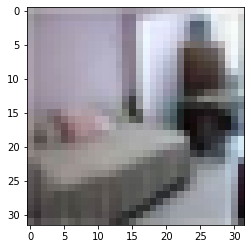

In [14]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [15]:
from mlp_mixer import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [16]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted, dim=1)
    return accuracy_score(predicted, true_labels)

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [17]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 10 #100 #512
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
num_layers = 3 #8
mlp_dc_dimension = 8 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 8 #128 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

num_epochs = 100
steps_total = len(train_loader)

hyper_params = {
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()

# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        true_labels = labels.to(device)
        
        # forward pass
        predicted = model(images)
        loss = loss_func(predicted, true_labels)
        train_accuracy += get_accuracy(predicted, true_labels)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    experiment.log_metric("train epoch loss", loss.item(), step=epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step=epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            true_labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, true_labels)
            val_accuracy += get_accuracy(predicted, true_labels)
        val_accuracy /= len(val_loader)
        experiment.log_metric("val epoch loss", loss.item(), step=epoch)
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 20 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wedrid/mlp-mixer/7892b7b1444341f4a86636ade0dd703f
COMET INFO:   Metrics:
COMET INFO:     mean train epoch accuracy : 0.01114285714285715
COMET INFO:     mean val epoch accuracy   : 0.021133333333333344
COMET INFO:     train epoch loss          : 4.542134761810303
COMET INFO:     val epoch loss            : 4.5225629806518555
COMET INFO:   Parameters:
COMET INFO:     batch_size                   : 250
COMET INFO:     epochs                       : 100
COMET INFO:     hidden_dim_size (n_channels) : 10
COMET INFO:     image_width_and_height       : 32
COMET INFO:     learning_rate                : 0.001
COMET INFO:     mlp_dc_dimension             : 8
COMET INFO:     mlp_ds_dimension             : 8
COMET INFO:     number_of_layers             : 3
CO

current dir is: /Users/edrid/Desktop/Machine learning/Project/mlp_mixer


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 1: 4.5583


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 2: 4.3636


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 3: 4.1034


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 4: 3.9784


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 5: 3.9740


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 6: 3.7868


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 7: 3.7748


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 8: 3.7031


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 9: 3.7144


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 10: 3.6157


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 11: 3.5753


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 12: 3.7284


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 13: 3.7337


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 14: 3.5292


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 15: 3.5928


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 16: 3.4704


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 17: 3.3907


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 18: 3.3394


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 19: 3.4307


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 20: 3.4937


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 21: 3.5167


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 22: 3.2163


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 23: 3.4303


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 24: 3.2117


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 25: 3.5728


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 26: 3.4177


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 27: 3.3586


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 28: 3.3934


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 29: 3.3628


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 30: 3.2719


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 31: 3.4190


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 32: 3.4244


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 33: 3.1995


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 34: 3.4279


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 35: 3.3782


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 36: 3.3450


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 37: 3.3429


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 38: 3.4409


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 39: 3.3312


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 40: 3.4022


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 41: 3.2591


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 42: 3.3460


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 43: 3.3343


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 44: 3.3033


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 45: 3.2608


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 46: 3.2422


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 47: 3.1950


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 48: 3.2220


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 49: 3.4505


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 50: 3.2247


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 51: 3.2521


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 52: 3.3877


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 53: 3.2700


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 54: 3.4227


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 55: 3.3606


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 56: 3.2687


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 57: 3.3059


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 58: 3.3344


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 59: 3.2046


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 60: 3.3381


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 61: 3.3444


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 62: 3.2122


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 63: 3.3006


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 64: 3.1407


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 65: 3.2002


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 66: 3.2664


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 67: 3.2760


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 68: 3.2511


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 69: 3.2706


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 70: 3.3380


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 71: 3.2408


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 72: 3.1648


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 73: 3.1827


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 74: 3.2410


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 75: 3.3138


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 76: 3.2541


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 77: 3.1398


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 78: 3.3337


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 79: 3.2557


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 80: 3.1371


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 81: 3.1409


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 82: 3.3404


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 83: 3.2073


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 84: 3.0081


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 85: 3.1483


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 86: 3.2546


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 87: 3.1383


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 88: 3.1971


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 89: 3.3082


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 90: 3.2490


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 91: 3.1338


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 92: 3.2633


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 93: 3.1954


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 94: 2.9654


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 95: 3.2136


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 96: 3.0272


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 97: 3.2697


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 98: 3.3255


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 99: 3.2372


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 100: 3.2584


  0%|          | 0/60 [00:00<?, ?it/s]

In [18]:
torch.save(model.state_dict(), model_path + f"final.pth")

In [19]:
examples = iter(train_loader)
images, labels = examples.next()

# metrics trial
images = images.to(device)
labels = labels.to(device)

# forward pass
outputs = model(images)
loss = loss_func(outputs, labels)

#da mettere nel ciclo
print(outputs.shape)

#####
predicted = torch.argmax(outputs, dim=1)
accuracy = accuracy_score(predicted, labels)
print(f'Accuracy {accuracy}')
#####
print(predicted.shape)
print(predicted)


torch.Size([250, 100])
Accuracy 0.22
torch.Size([250])
tensor([24, 41, 14,  1, 89, 95, 16, 20, 30, 30, 57, 27,  8, 68, 71, 40, 82, 70,
        47, 93, 24, 62, 91, 17, 33, 90, 71, 20, 87,  7, 23, 70,  5, 68, 41, 91,
        17, 82, 33, 97, 73, 52,  4, 82, 52, 64, 42, 71, 38, 36, 92, 30, 90,  0,
        60, 76, 85, 67, 76, 95, 35, 67, 33, 69, 36, 37, 63, 20, 92, 86, 64, 28,
        68,  0, 48, 52, 21, 28, 37, 56, 53, 20, 52, 24, 56, 60, 51, 62, 48, 53,
        96, 91, 39, 87, 61,  8, 23, 68, 44, 61,  6, 59, 93,  9, 42, 22, 63, 68,
        96, 24, 88, 99, 75, 76, 60, 85, 43, 12, 33, 97, 52, 53, 76, 48, 63, 17,
        22, 15, 91, 39, 62, 68, 51, 83, 33, 82, 74,  2, 12, 74, 85, 83, 64, 28,
        53, 12, 88, 61, 83, 61, 39,  8, 38, 62, 85, 61, 49, 63, 49, 18, 85,  5,
        24, 66, 98, 53, 56, 87, 42, 31, 91, 61, 64, 69, 45, 37, 94, 61, 47, 94,
         6, 56, 12, 60,  5, 76, 14, 41, 88, 17, 67, 21,  9, 29, 16, 85, 79, 41,
        79,  2, 65, 23, 12, 36, 53, 93, 96, 86, 73, 61, 27, 63, 1